# Readme
Here's a program I made to help automate grading for a specific type of questionaire. The programming is very case specific and not very robust but it might show some techniques that could be helpful to similar cases.

# Import Modules

In [43]:
import cv2
import numpy as np 
import imutils
from imutils import contours
import sys
import matplotlib.pyplot as plt
%matplotlib inline


# Variables

In [37]:

img = 'test_final.jpg'
imgsize = (1250,1000)

#imgsmall = 
cwidth_min = 100
cheight_min = 20
cratio_min = 3.0
cratio_max = 8.0
dic = {0:100,1:50,2:100,3:100,4:100}
it = 2

answerlist = []
answerdic = {}
logdic = {}

# Display original

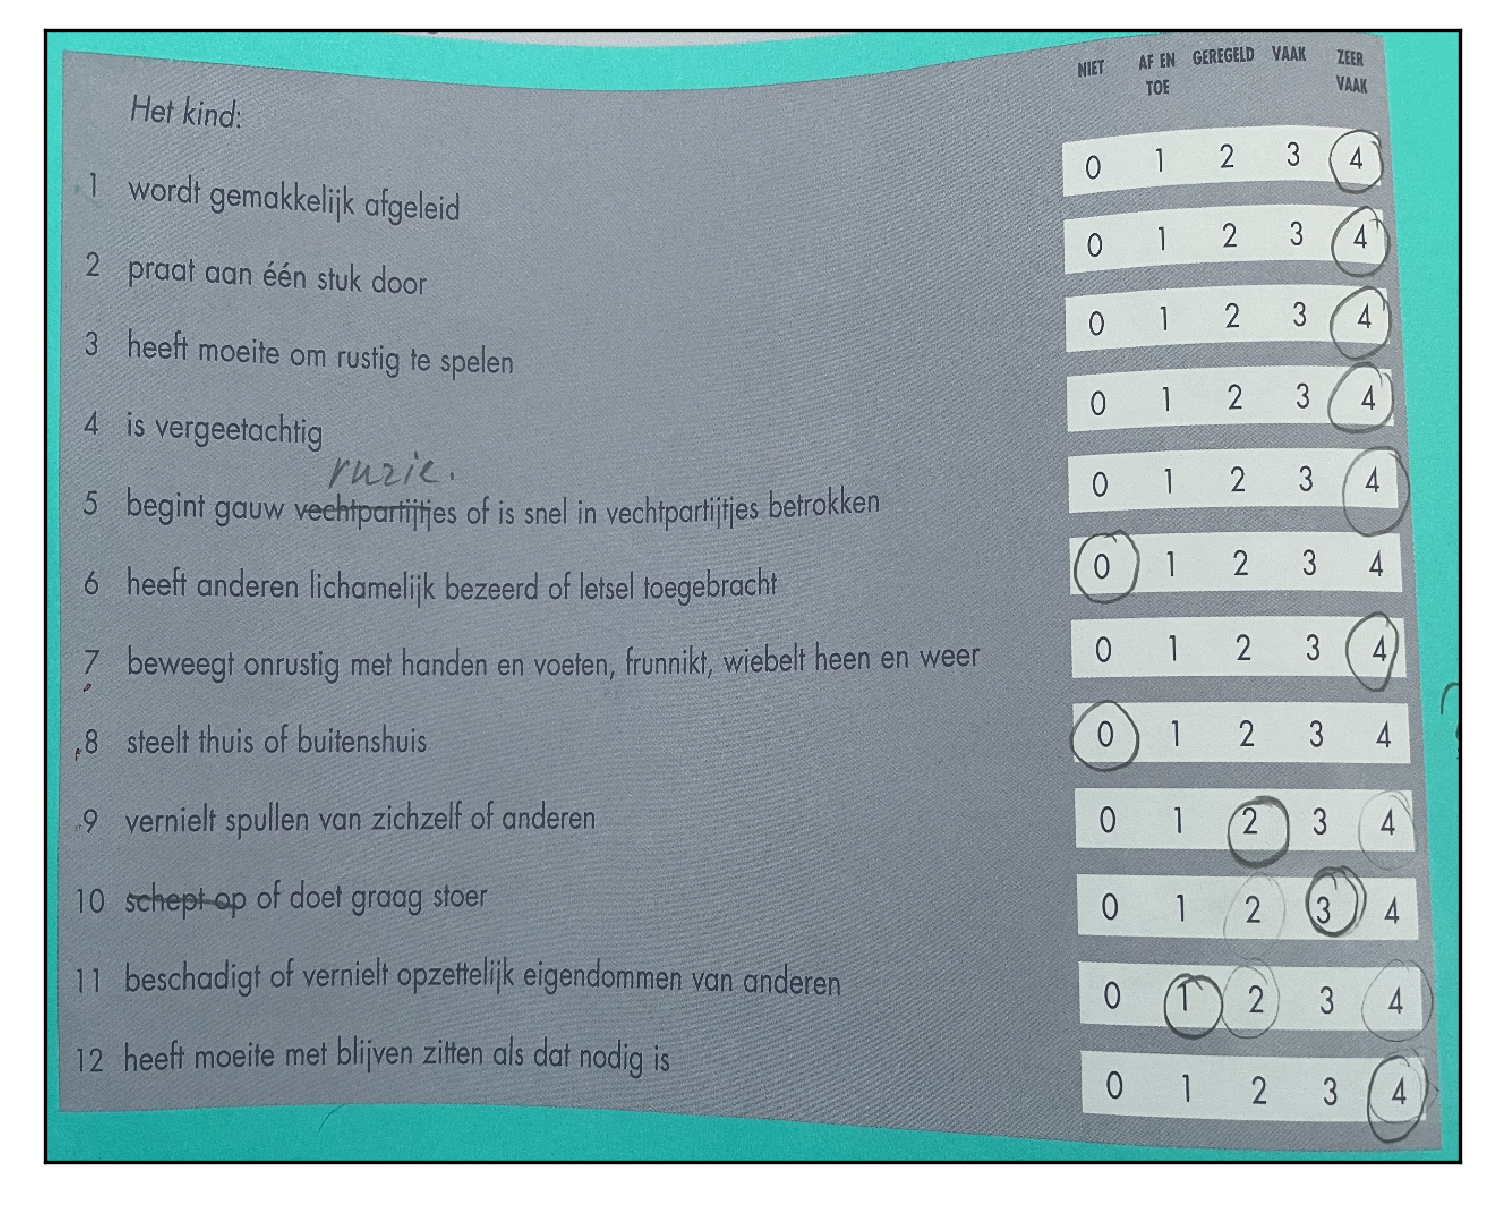

In [64]:
image= cv2.imread(img)
image = cv2.resize(image, imgsize) #resize image
plt.imshow(image)
plt.rcParams['figure.dpi'] = 300
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
plt.show()


# Load images and prepare for contour detection

In [32]:
image= cv2.imread(img)
image = cv2.resize(image, imgsize) #resize image



gray= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #grayscale (no rgb)
blurred= cv2.GaussianBlur(gray, (5,5), 0)#grainyness disapears
thresh= cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV| cv2.THRESH_OTSU)[1] #turn it into binary - black or white


#some morphing applications to be able to detect all countours    
eroded = cv2.erode(thresh.copy(), None, iterations= it+1)
morphed = cv2.dilate(eroded, None, iterations=it+4)
eroded = cv2.erode(morphed.copy(), None, iterations= it+4)
morphed = cv2.dilate(eroded, None, iterations=it+1)

#get edges for contour detection
edged= cv2.Canny(morphed, 75, 200)




-1

# Display of edged and threshold transformation

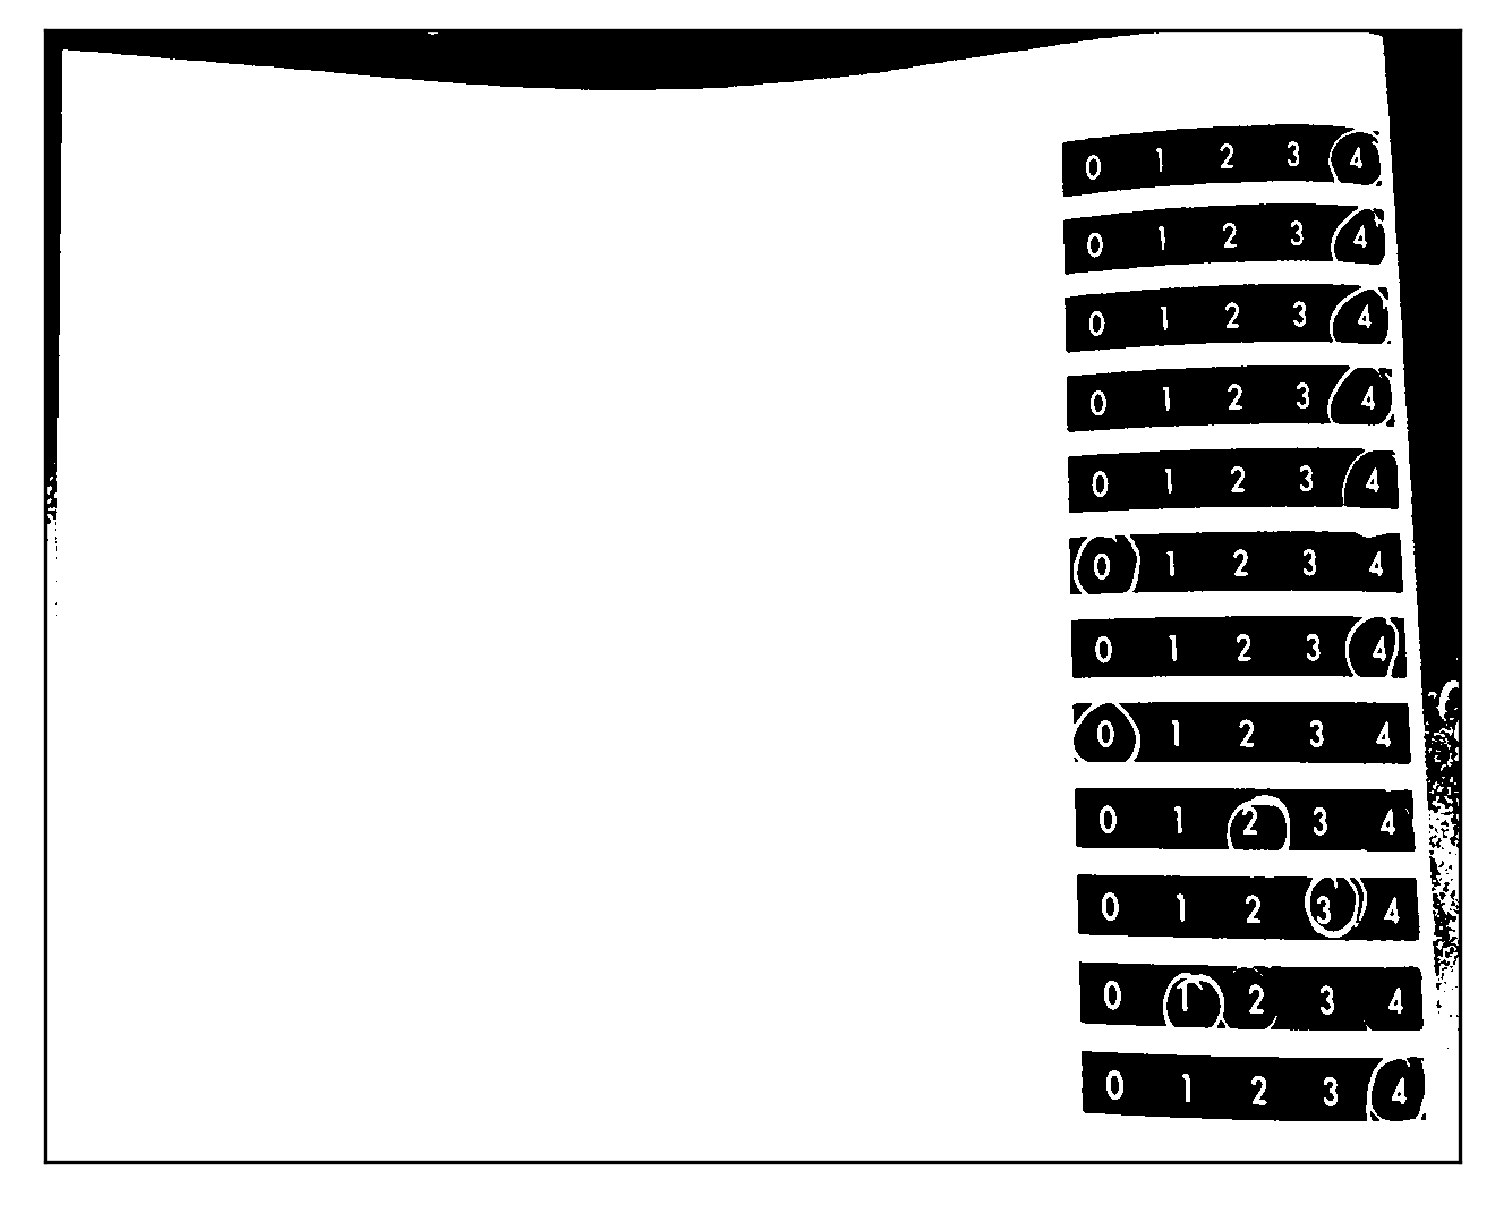

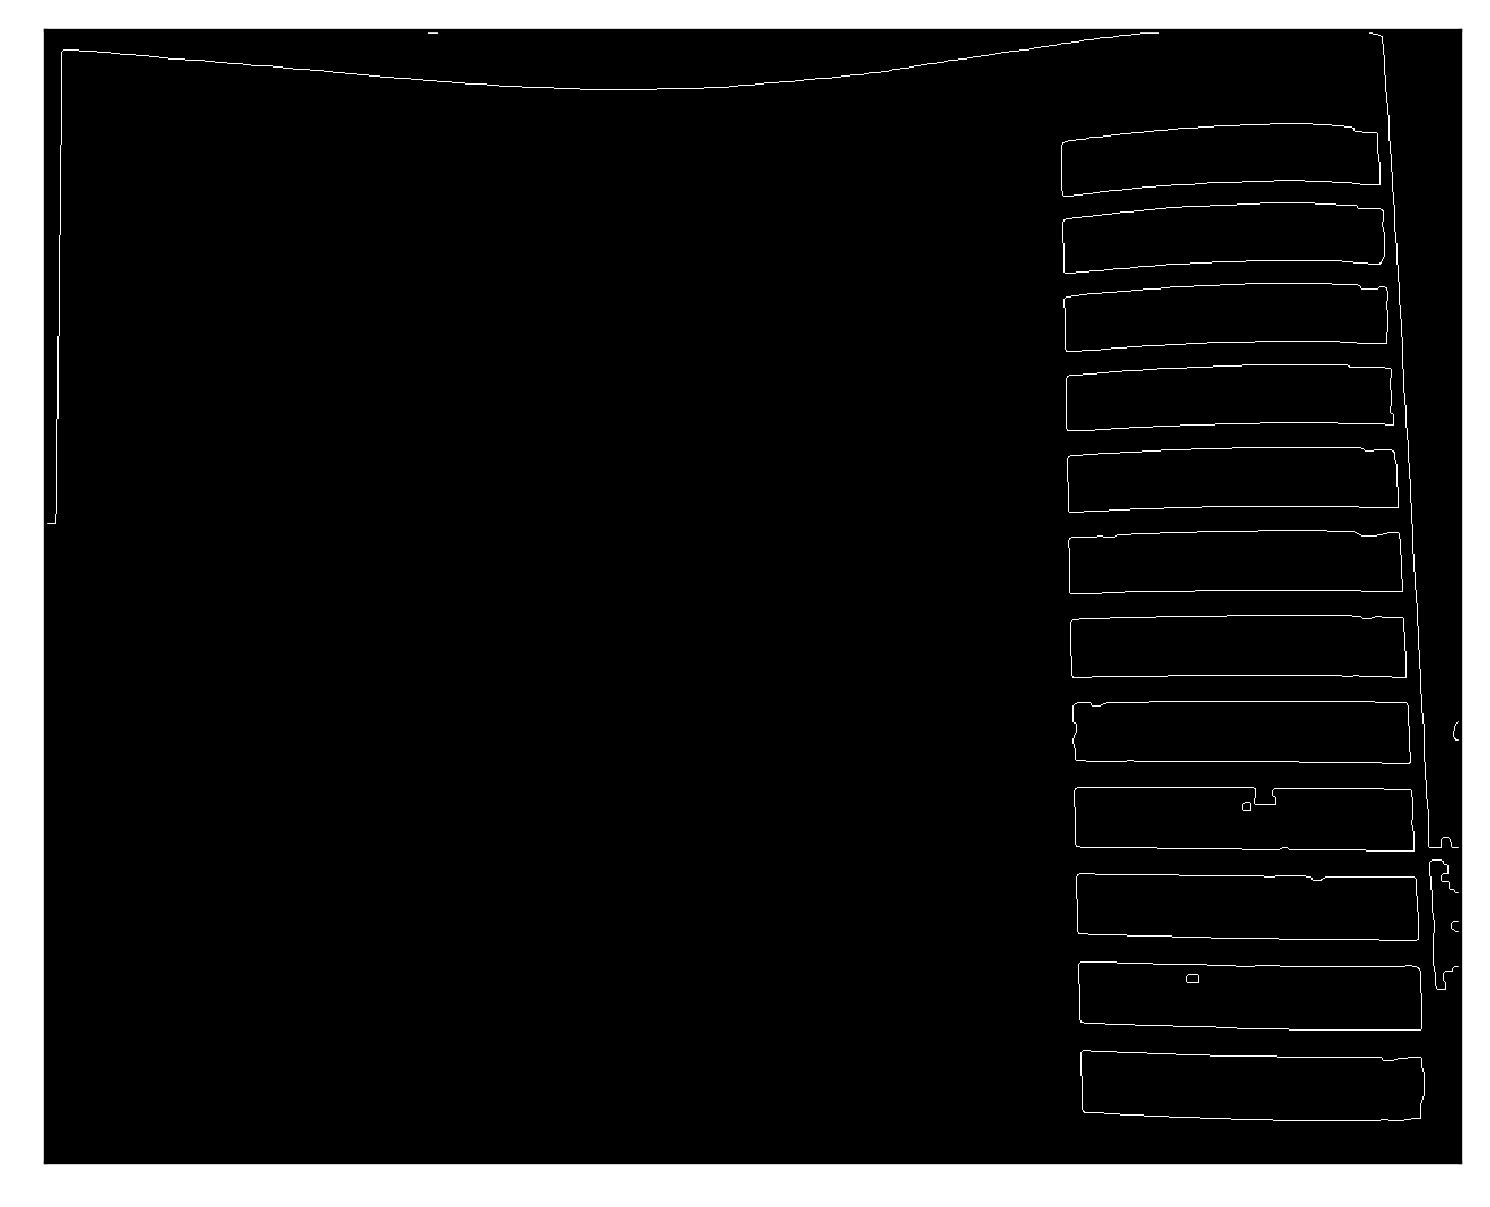

In [63]:
plt.imshow(thresh,cmap='gray')
plt.rcParams['figure.dpi'] = 300
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
plt.show()

plt.imshow(edged,cmap='gray')
plt.rcParams['figure.dpi'] = 300
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
plt.show()

# Detect contours and filter for the correct contours

In [50]:
cnts= cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cnts= imutils.grab_contours(cnts)

#check if contours are detected
#imgContours = image.copy() # COPY IMAGE FOR DISPLAY PURPOSE
#cv2.drawContours(imgContours, cnts, -1, (0, 255, 0), 2)
#cv2.imshow('hoi',imgContours)
#cv2.waitKey(0)

row = []
for c in cnts:
    (x, y, w, h)= cv2.boundingRect(c) #get a rectangle cutout of the contour with its locations and width and height
    ar= w/ float(h) #ratio is a good identifying character
    if w>=cwidth_min and h>=cheight_min and ar >=cratio_min and ar<= cratio_max: # might require tweaking
        row.append(c)
        
#sorting the contours from top to botton
row= contours.sort_contours(row, method="top-to-botton")[0]




# Visual Check for correct filtered contours

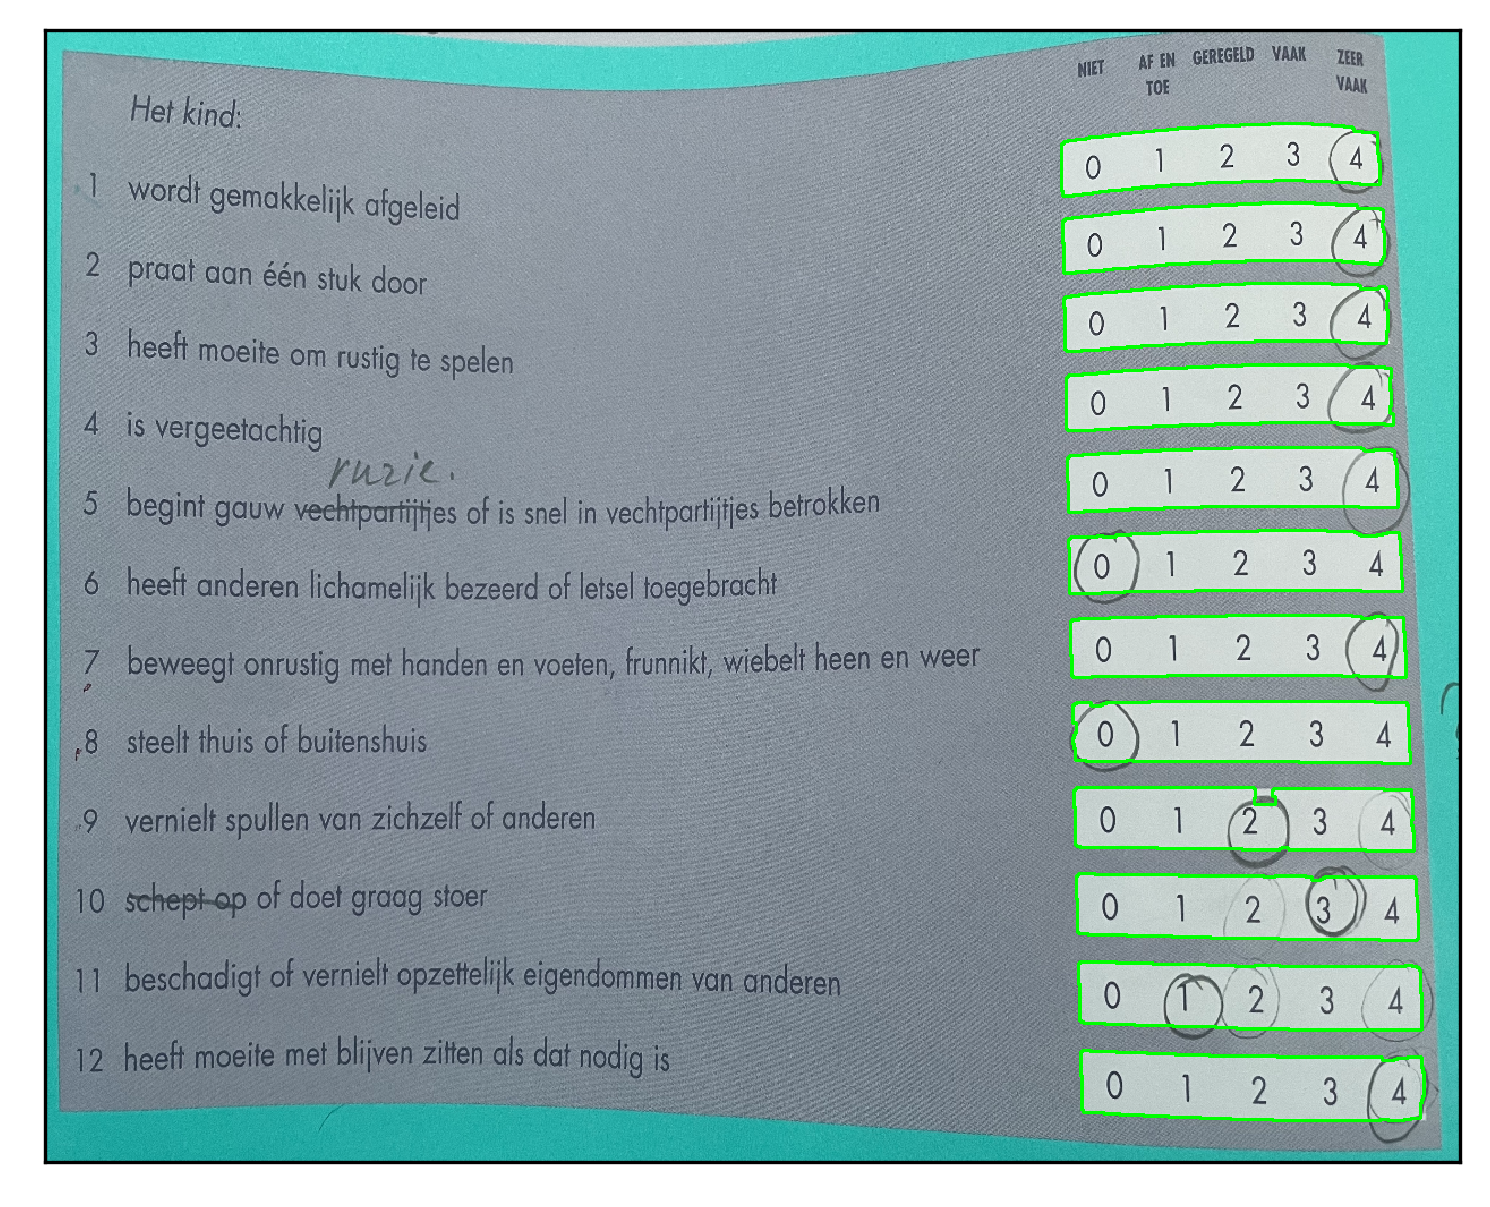

In [57]:
#check if correct contours are filtered
imgContours = image.copy() # COPY IMAGE FOR DISPLAY PURPOSE
cv2.drawContours(imgContours, row, -1, (0, 255, 0), 2)
plt.imshow(imgContours)
plt.rcParams['figure.dpi'] = 300
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
plt.show()

# Extract each contour, cut it in 5 pieces, compare each piece and determine which 1 has been circled

In [38]:

for a,score in enumerate(row):
    (x, y, w, h)= cv2.boundingRect(score) # get boundries of the the contour
    
    mask = np.zeros(thresh.shape, dtype="uint8")#black mask
    
    cv2.drawContours(mask, [score], -1, 255, -1)#cutout space for the contour
    mask= cv2.bitwise_and(thresh, thresh, mask=mask)#insert contour
    
    
    cutout = mask.copy()
    cutout = cutout[y:y+h, x:x+w] #cutout the contour from the mask
    
      
    cols =np.array_split(cutout,5,axis =1)# split cutout in 5 equal pieces
    antw = None #highest score in row
    boxes = []
    for i,box in enumerate(cols):
      
        total= cv2.countNonZero(box) - dic[i] #total white pixels compensated for number size
        
        
        if antw is None : #search for the biggest answer
            antw= (total, i)
        elif total >antw[0]:
            antw= (total, i)
            
    if antw[0] < 40: #check for non filled rows
        antw = ("vraag " + str(a)+ ' is niet goed ingevuld of ontbreekt. Hiervoor is 0 ingevuld.',0)
    
    answerlist.append(antw[1]) #list of correct awnsers
    answerdic[a+1] = antw[1] # dic of correct answerd with keys
    logdic[a+1] = antw[0]
print(answerlist)
print(answerdic)
print(logdic)

[4, 4, 4, 4, 4, 0, 4, 0, 2, 3, 1, 4]
{1: 4, 2: 4, 3: 4, 4: 4, 5: 4, 6: 0, 7: 4, 8: 0, 9: 2, 10: 3, 11: 1, 12: 4}
{1: 260, 2: 300, 3: 349, 4: 318, 5: 189, 6: 494, 7: 477, 8: 533, 9: 359, 10: 571, 11: 554, 12: 432}


# Visual Check to see if the correct answer has been circled

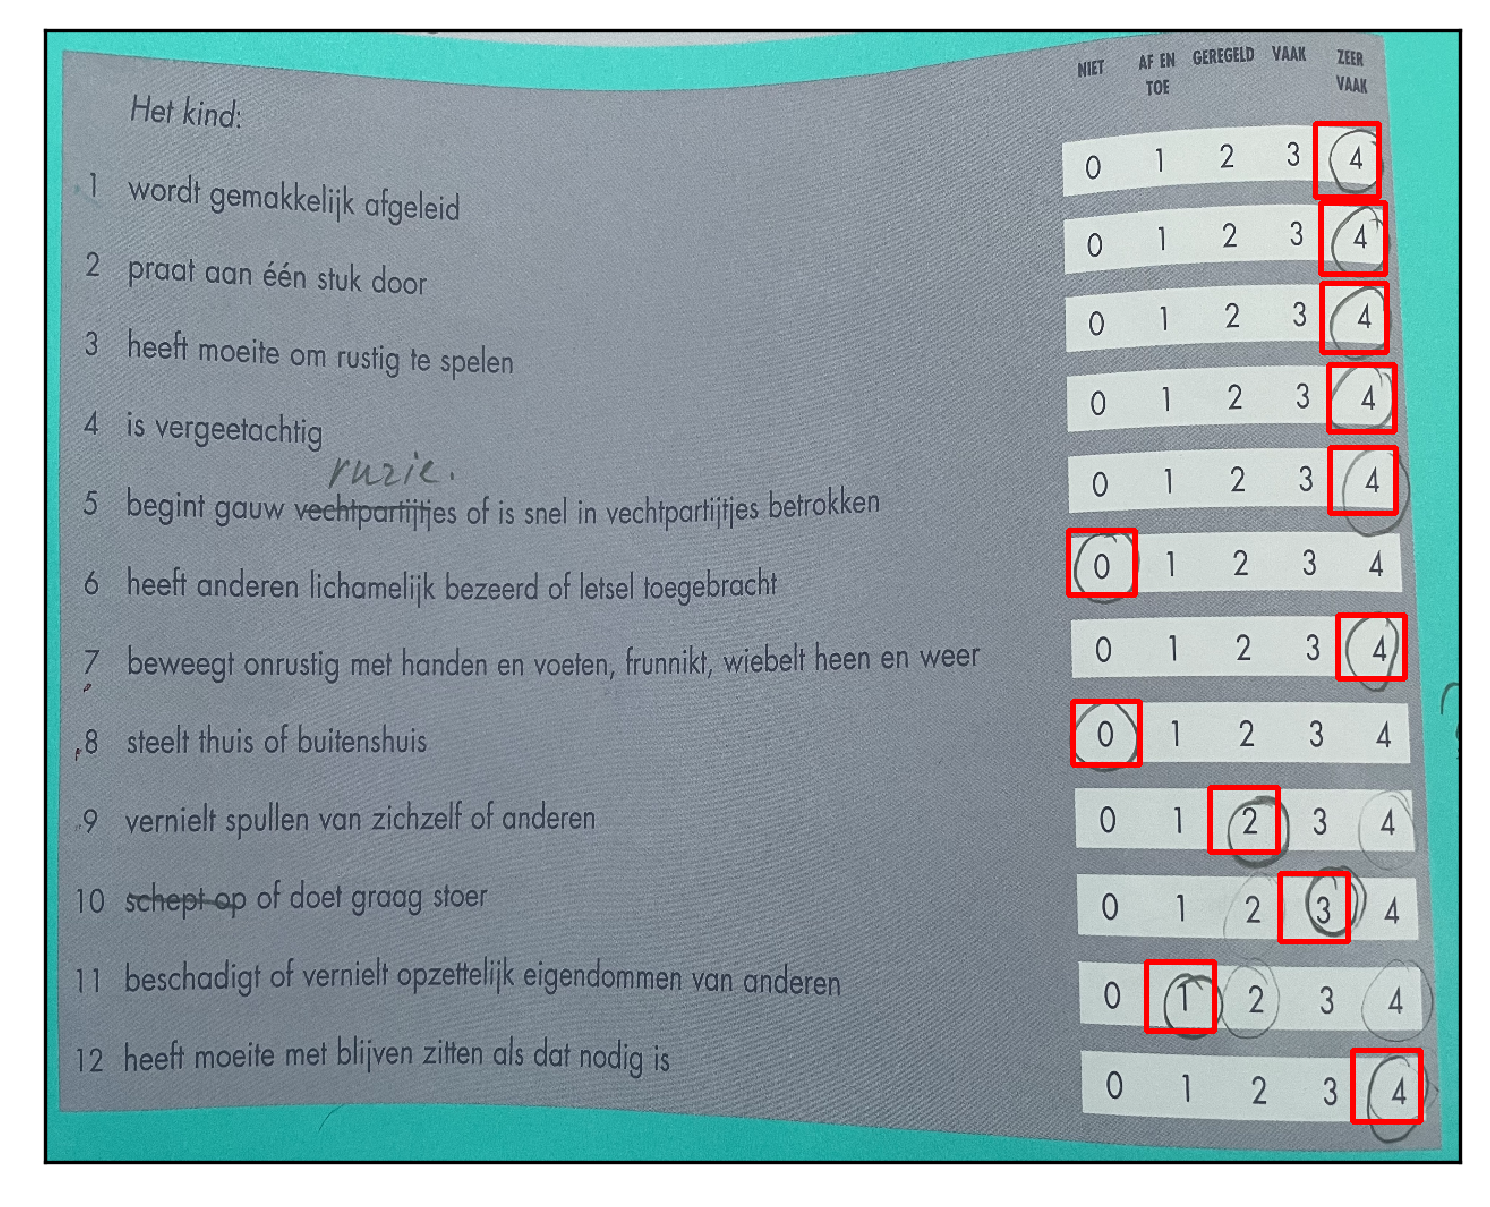

In [58]:
image3 = image.copy()
for a,score in enumerate(row):
    (x, y, w, h)= cv2.boundingRect(score) # get boundries of the the contour
    #draw rectangle around each found answer
    cv2.rectangle(image3,((x+int(w/5)*(answerdic[a+1])),y),((x+int(w/5)*(answerdic[a+1])+int(w/5)),y+h),(255,0,0),3)
    






plt.imshow(image3)
plt.rcParams['figure.dpi'] = 300
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
plt.show()